In [2]:
import platform, sys    
print(platform.python_implementation()) #python interpreter
print(sys.version) #python version

CPython
3.10.9 (tags/v3.10.9:1dd9be6, Dec  6 2022, 20:01:21) [MSC v.1934 64 bit (AMD64)]


In [189]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# The basic salvo combat model
as per: Michael J Armstrong (2014) The salvo combat model with a sequential
exchange of fire, Journal of the Operational Research Society, 65:10, 1593-1601, DOI: 10.1057/
jors.2013.115


In [84]:
# battle model parameters
class PlayerState():
    def __init__(self, N, offPower, defPower, stayPower):
        self.N = N  # number of units
        # number of missiles (accurately) fired per unit per salvo
        self.offPower = offPower
        self.defPower = defPower  # number of missiles intercepted per unit per salvo
        # staying power, how many hits a unit can take from opponent.
        self.stayPower = stayPower
        return (None)


class Game():
    def __init__(self, red: PlayerState, blue: PlayerState):
        self.red = red
        self.blue = blue
        return (None)

    def battle(self):

        # helper function to get lost number of units each round of battle.

        def get_delta_N(P1: PlayerState, P2: PlayerState):
            deltaP1 = (P2.offPower*P2.N - P1.defPower*P1.N)*(1/P1.stayPower)
            deltaP1 = max(0, min(deltaP1, P1.N))
            return (deltaP1)

        # loop while both players still have units
        it = 0
        while (self.red.N > 0 and self.blue.N > 0 and it < 50):
            

            red_delta_N = get_delta_N(self.red, self.blue)
            blue_delta_N = get_delta_N(self.blue, self.red)
               
            self.red.N = self.red.N - red_delta_N         
            self.blue.N = self.blue.N - blue_delta_N
            it +=1  
            print(f"Nred :{self.red.N}, Nblue : {self.blue.N} ")
            
        return (self)


In [85]:
blue_player = PlayerState(N=6, offPower=2, defPower=1, stayPower=6)
red_player = PlayerState(N=6, offPower=2, defPower=1, stayPower=7)

game = Game(blue=blue_player, red = red_player)
game = game.battle()


Nred :5.142857142857143, Nblue : 5.0 
Nred :4.448979591836736, Nblue : 4.119047619047619 
Nred :3.90767735665695, Nblue : 3.3225623582766435 
Nred :3.51661344810033, Nblue : 2.573763632437101 
Nred :3.283625759989777, Nblue : 1.8305197551431744 
Nred :3.22970950994741, Nblue : 1.0410644610037778 
Nred :3.22970950994741, Nblue : 0.13800536785527084 
Nred :3.22970950994741, Nblue : 0.0 


In [86]:

# getState: sigmoid(sum(aktions))
# makeAktion: optmizied decision
# evalUtility: game()


# Sequential Stochastic salvo combat model 
as per: Michael J Armstrong (2014) The salvo combat model with a sequential
exchange of fire, Journal of the Operational Research Society, 65:10, 1593-1601, DOI: 10.1057/
jors.2013.115


In [245]:
# battle model parameters
class PlayerState():
    def __init__(self, N=5, offNumber=8, offProb=1/2, offDamage=1,  defNumber=4, defProb=1/5, stayPower=3):
        self.N = N  # number of units
        self.offNumber = offNumber
        self.offProb = offProb
        self.offDamage = offDamage

        self.defNumber = defNumber
        self.defProb = defProb
        self.stayPower = stayPower
        
        return (None)


class Game():
    def __init__(self, red: PlayerState, blue: PlayerState):
        self.red = red
        self.blue = blue
        return (None)

    def battle(self):

        # helper function to get lost number of units each round of battle.
        # P2 attacking P1
        def getPlayerN(P1: PlayerState, P2: PlayerState):

            mu_p2_off = P2.offNumber*P2.offProb
            var_p2_off = P2.offNumber * P2.offProb*(1-P2.offProb)

            mu_p1_def = P1.defNumber*P1.defProb
            var_p1_def = P1.defNumber*P1.defProb*(1-P1.defProb)

            # draw from normal distribution
            netOffHits = norm.rvs(size=1, 
                loc=(P2.N*mu_p2_off-P1.N*mu_p1_def),
                scale=(P2.N*var_p2_off + P1.N*var_p1_def)**.5
            )
           

            
            net_kwargs = {"loc" : (P2.N*mu_p2_off-P1.N*mu_p1_def) , "scale" : (P2.N*var_p2_off + P1.N*var_p1_def)**.5}
            print("net", net_kwargs)
            
            mu_v = P2.offDamage / P1.stayPower #average number of ships sunk per hit
            print("mu_v", mu_v)
            var_v = (mu_v / 2.5)**2 # variance in number of ships sunk per hit
            #var_v = 0
            
            
            #first calculate terms relating to the nominal surviving force
            mu_p1_N_nominal = P1.N - (P2.N*mu_p2_off - P1.N*mu_p1_def)* mu_v
            
            var_p1_N_nominal = (P2.N*mu_p2_off - P1.N*mu_p1_def)*var_v + (P2.N*var_p2_off + P1.N*var_p1_def)*mu_v**2     \
                - 2*var_v*(P2.N*mu_p2_off - P1.N*mu_p1_def) * norm.cdf(0, **net_kwargs)      \
                + 2*var_v*(var_p2_off**2 + var_p1_def**2)*norm.pdf(0,**net_kwargs)
            
            nominal_kwargs = {"loc" : mu_p1_N_nominal, "scale" : var_p1_N_nominal**.5}
            print("nominal",nominal_kwargs)

            
            #calulate the actual surviving force
            mu_p1_N = mu_p1_N_nominal * ( norm.cdf(P1.N - mu_v/2, **nominal_kwargs) - norm.cdf(mu_v/2, **nominal_kwargs)) \
                - var_p1_N_nominal*(norm.pdf(P1.N-mu_v/2, **nominal_kwargs) - norm.pdf(P1.N + mu_v/2, **nominal_kwargs)) \
                + P1.N*(1 - norm.cdf(P1.N - mu_v/2, **nominal_kwargs) )
            

            # problem uppstår när mu_p1_N -> 0 
            # var_p1_N blir negativ och roten är ej definierad
            var_p1_N = (mu_p1_N_nominal**2 + var_p1_N_nominal)*(norm.cdf(P1.N -mu_v/2, **nominal_kwargs) - norm.cdf(mu_v/2 ,**nominal_kwargs)) \
                + P1.N**2 * (1 - norm.cdf(P1.N - mu_v/2, **nominal_kwargs)) \
                - mu_p1_N**2 \
                - var_p1_N_nominal *((P1.N - mu_v/2 + mu_p1_N_nominal)*norm.pdf(P1.N - mu_v/2,**nominal_kwargs)-(mu_v/2 + mu_p1_N_nominal)*norm.pdf(mu_v/2,**nominal_kwargs)  )
            
            

            if(var_p1_N < 0):
                print(var_p1_N)
            
            actual_kwargs = {"loc":mu_p1_N, "scale" : var_p1_N**.5}
            print("actual",actual_kwargs)
            
            # # print({"loc":mu_p1_N, "scale" : var_p1_N})
            
            
            draw_p1_N = norm.rvs(size=1, **actual_kwargs)
            
            
            return draw_p1_N 
        # loop while both players still have units
        it = 0
        while (self.red.N > 0 and self.blue.N > 0 and it < 50):

            #simultaneous attack
            red_new_N = getPlayerN(self.red, self.blue)
            blue_new_N = getPlayerN(self.blue, self.red)

            self.red.N = red_new_N
            self.blue.N = blue_new_N
            it += 1
            print(f"Nred :{self.red.N}, Nblue : {self.blue.N} ")

        return (self)


In [246]:
blue_player = PlayerState(N=4,defNumber=8)#, stayPower=2)
red_player = PlayerState(N=4, defNumber=8)#, stayPower=14)

game = Game(blue_player, red_player)
game = game.battle()




net {'loc': 9.6, 'scale': 3.622154055254967}
mu_v 0.3333333333333333
nominal {'loc': 0.8000000000000003, 'scale': 1.275825558323298}
actual {'loc': 0.5655516799972903, 'scale': 1.2885268292066832}
net {'loc': 9.6, 'scale': 3.622154055254967}
mu_v 0.3333333333333333
nominal {'loc': 0.8000000000000003, 'scale': 1.275825558323298}
actual {'loc': 0.5655516799972903, 'scale': 1.2885268292066832}
Nred :[2.54190068], Nblue : [0.35378673] 
net {'loc': array([-2.65189418]), 'scale': array([1.99027795])}
mu_v 0.3333333333333333
nominal {'loc': array([3.42586541]), 'scale': array([0.70370797])}
[-0.84667597]
actual {'loc': array([2.67664155]), 'scale': array([nan])}


C:\Users\IsakG\AppData\Local\Temp\ipykernel_30408\3085890855.py:80: RuntimeWarning: invalid value encountered in sqrt
  actual_kwargs = {"loc":mu_p1_N, "scale" : var_p1_N**.5}


ValueError: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.norm` documentation for details.

In [ ]:


n = 1000
blue_survivors = np.ndarray(n)
red_survivors = np.ndarray(n)
for i in range(n):
    
    game =  Game(blue_player, red_player).battle()
    blue_survivors[i] = game.blue.N
    red_survivors[i] = game.red.N   
    
plt.plot(range(n),blue_survivors)
plt.plot(range(n),red_survivors)

In [200]:
blue_survivors[3] = 1
blue_survivors

array([1.274292, 1.274292, 1.274292, 1.      , 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274292,
       1.274292, 1.274292, 1.274292, 1.274292, 1.274292, 1.274

In [10]:
distr_kwargs =  {"loc" : 3, "scale" : 0.001}
norm.rvs(size=5,**distr_kwargs)

array([2.99731665, 3.00115284, 3.00082951, 3.00128126, 3.00074853])

Frigate (100%) OP: 4 DP: 4


Battle starts between BLUFOR and REDFOR


Pulse 0:
BLUFOR: 100.0% (2 active ships) | REDFOR: 100.0% (3 active ships)

Pulse 1:
BLUFOR: 0.0% (0.0 active ships) | REDFOR: 88.67% (2.66 active ships)


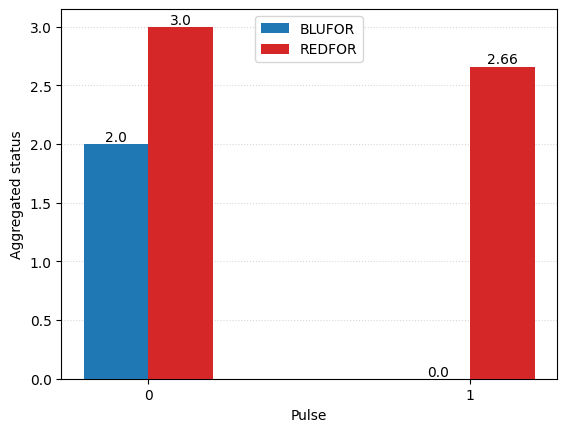

In [248]:
# https://github.com/doolanshire/Combat-Models/blob/master/salvo/deterministicSalvoNoLeakers.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Dec 19 2017

@author: Alvaro Radigales

A Python implementation of the Deterministic Salvo Model created by Wayne P. Hughes Jr.

The results are consistent with those found in the works of Hughes, Cares, McGunnigle,
Tiah et al. The included classes have been given default values in some attributes to
account for the different versions of the model.


"""

import matplotlib.pyplot as plt
import numpy as np

class Ship:
    ''' A ship carrying anti-ship cruise missiles.
    
    Attributes:
        * type (str): the type of ship, for labeling purposes only.
        * op (int): the number of anti-ship cruise missiles the ship can fire in one salvo.
        * dp (int): the number of SAM the ship can fire in one salvo against incoming missiles.
        * sp (float): initial staying power in missile hits.
        * hp (float): hit points remaining.
        * status (fraction): fraction of its staying power remaining. 1 is intact, 0 is OOA.
    '''
    
    def __init__(self, type, op, dp, sp):
        self.type = type
        self.op = op
        self.dp = dp
        self.sp = sp
        self.hp = sp
        self.status = 1
        
    def damage(self, damage):
        ''' Lowers the ship's 'hp' attribute by the input amount.
        
        Args:
            * damage (float): points of damage to subtract. HP cannot go below 0.
        '''
        damage = min(damage, self.hp)
        damage = max(damage, 0)
        self.hp -= damage
        self.status = self.hp / self.sp
        
    def ascm_fire(self):
        ''' Returns cruise missile salvo size based on status.'''
        return self.op * self.status
        
    def sam_fire(self):
        ''' Returns SAM salvo size based on status.'''
        return self.dp * self.status
        
    def __str__(self):
        ''' String override. Returns ship type, status as percentage, OP, and DP.'''
        shipStatus = round(self.status * 100, 2)
        shipOp = round(self.ascm_fire(), 2)
        shipDp = round(self.sam_fire(), 2)
        shipString = "{} ({}%) OP: {} DP: {}\n".format(self.type, shipStatus, shipOp, shipDp)
        return shipString
        
class Missiles:
    ''' The specification of the missile systems carried by a group of ships.
    
    Attributes:
        * launch_reliability (fraction): fraction of cruise missiles that launch successfully.
        * ascm_to_hit (fraction): fraction of cruise missiles that hit, in the absence of defences.
        * sam_to_hit (fraction): fraction of SAM that successfully intercept incoming missiles.
    '''
    def __init__(self, launch_reliability = 1, ascm_to_hit = 1, sam_to_hit = 1):
        self.launch_reliability = launch_reliability
        self.ascm_to_hit = ascm_to_hit
        self.sam_to_hit = sam_to_hit
        
    def offensive_modifier(self):
        ''' Returns the fraction of missiles that launch AND hit.'''
        return self.launch_reliability * self.ascm_to_hit

class Group:
    ''' A group of ships.
    
    Attributes:
        * side (str): the group's side identifier, for labelling purposes.
        * ship (Ship): the ship type the group is composed of.
        * units (int): the number of ships of type (ship) in the group.
            * oob (list): a list of Ship objects representing the group.
        * scouting (fraction): fraction of enemy group that can be located and targeted.
        * readiness (fraction): efficiency of the group's defences.
        * missiles (Missiles): the missile systems used by the group.
    '''
    def __init__(self, side, ship, units, scouting = 1, readiness = 1, missiles = Missiles()):
        self.side = side
        self.oob = [Ship(ship.type, ship.op, ship.dp, ship.sp) for i in range(units)]
        self.scouting = scouting
        self.readiness = readiness
        self.missiles = missiles
        
    def striking_power(self):
        ''' Returns the raw striking power of the group.'''
        salvoSize = sum(ship.ascm_fire() for ship in self.oob)
        strikingPower = salvoSize * self.scouting * self.missiles.offensive_modifier()
        return strikingPower
        
    def defensive_power(self):
        ''' Returns the raw defensive power of the group.'''
        defensiveSalvoSize = sum(ship.sam_fire() for ship in self.oob)
        defensivePower = defensiveSalvoSize * self.readiness * self.missiles.sam_to_hit
        return defensivePower
        
    def combat_power(self, enemy):
        ''' Returns the combat power in excess of the enemy's defences.
        
        Arguments:
            * enemy (Group): the target group.
        '''
        return max(0, (self.striking_power() - enemy.defensive_power()))
        
    def total_status(self):
        ''' Returns the sum of the 'status' attributes of all ships in the group.'''
        return sum(i.status for i in self.oob)
        
    def damage(self, damage):
        ''' Damages the group. Applied to all ships consecutively until damage reaches
        zero, or no more targets are available.
        
        Arguments:
            * damage (float): the total amount damage to inflict upon the group.
        ''' 
        while damage > 0 and self.total_status() > 0:
            for i in self.oob:
                if i.status > 0:
                    if damage > i.hp:
                        damage -= i.hp
                        i.damage(i.hp)
                    else:
                        i.damage(damage)
                        damage = 0
        
    def __str__(self):
        ''' String override. Returns the percentage of the original staying power remaining,
        and the (equivalent) number of active ships.
        '''
        percentage = round((self.total_status() / len(self.oob)) * 100, 2)
        activeShips = round(self.total_status(), 2)
        groupString = "{}: {}% ({} active ships)".format(self.side, percentage, activeShips)
        return groupString
        
class Battle:
    ''' A battle between two groups.
    
    Attributes:
        * blu (Group): the BLUFOR group.
        * red (Group): the REDFOR group.
        * duration (int): the duration of the battle in pulses. If zero (default) the
        battle goes on until one side is wiped out.
    '''
    def __init__(self, blu, red, duration = 0):
        self.blu = blu
        self.red = red
        self.duration = duration
        self.pulse = 0
        # Lists for plotting
        self.bluPlot = [self.blu.total_status()]
        self.redPlot = [self.red.total_status()]
        self.time = [0]
        
    def add_to_plot(self):
        self.bluPlot.append(self.blu.total_status())
        self.redPlot.append(self.red.total_status())
        self.time.append(self.pulse)
        
    def stalemate(self):
        ''' Checks whether the battle has reached a stalemate. Only possible if SAM fire
        is 100% effective for both sides (missile sam_to_hit = 1)'''
        stalemate = self.blu.combat_power(self.red) == 0 and self.red.combat_power(self.blu) == 0
        return stalemate
        
    def blu_surprise(self):
        ''' Fires one BLUFOR salvo at REDFOR, without retaliation.'''
        if self.pulse == 0:
            print("\nBattle starts between {} and {}\n".format(self.blu.side, self.red.side))
            print(self)
        self.pulse += 1
        self.red.damage(self.blu.combat_power(self.red))
        print(self)
        # Add new values to the plotting lists
        self.add_to_plot()
        
    def red_surprise(self):
        ''' Fires one REDFOR salvo at BLUFOR, without retaliation.'''
        if self.pulse == 0:
            print("\nBattle starts between {} and {}\n".format(self.blu.side, self.red.side))
            print(self)
        self.pulse += 1
        self.blu.damage(self.red.combat_power(self.blu))
        print(self)
        # Add new values to the plotting lists
        self.add_to_plot()
        
    def salvo(self):
        ''' Both sides fire at each other simultaneously.'''
        if self.pulse == 0:
            print("\nBattle starts between {} and {}\n".format(self.blu.side, self.red.side))
            print(self)
        bluDamageSustained = self.red.combat_power(self.blu)
        redDamageSustained = self.blu.combat_power(self.red)
        self.blu.damage(bluDamageSustained)
        self.red.damage(redDamageSustained)
        self.pulse += 1
        print(self)
        # Add new values to the plotting lists
        self.add_to_plot()
        
    def resolve(self):
        ''' The battle is resolved for the specified duration, or until one side is wiped out.'''
        if self.duration == 0:
            while self.blu.total_status() != 0 and self.red.total_status() != 0:
                self.salvo()
                # Add new values to the plotting lists
                self.add_to_plot()
                if self.stalemate():
                    print("\nStalemate! Neither fleet can penetrate enemy missile defence.")
                    break
        else:
            for _ in range(self.duration):
                self.salvo()
                # Add new values to the plotting lists
                self.add_to_plot()

    

    def plot(self):
        x = np.array(self.time)
        y = np.array(self.bluPlot)
        z = np.array(self.redPlot)
        
        width = 0.2
        
        fig, ax = plt.subplots()
        rects1 = ax.bar(x-0.1, y, width, color='tab:blue', zorder=3)
        rects2 = ax.bar(x+0.1, z, width, color='tab:red', zorder=3)
        
        ax.set_ylabel('Aggregated status')
        ax.set_xlabel('Pulse')
        
        ax.set_xticks(x)
        #ax.set_yticks(np.arange(0,max(max(y),max(z))+1,1))
        
        ax.legend((rects1[0],rects2[0]),(self.blu.side,self.red.side), loc=9)
        
        ax.grid(which='major', axis='y', linestyle=':', alpha=0.5, zorder=0)
        ax.grid(which='minor', axis='y', linestyle=':', alpha=0.25, zorder=0)
        
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.text(rect.get_x() + rect.get_width()/2., height,
                '{}'.format(round(height,2)),
                ha='center', va='bottom')
        
        autolabel(rects1)
        autolabel(rects2)
        plt.show()
        
        
    def __str__(self):
        ''' String override. Returns the pulse number, and the status of the opposing groups.'''
        battleString = "\nPulse {}:\n{} | {}".format(self.pulse, str(self.blu), str(self.red))
        return(battleString)
    
# Test battle. Scenario taken from Cares, page 23, Scenario VI

# Knox-Class frigate     
frigate = Ship("Frigate", 4, 4, 2)
# String override demo
print(frigate)

# Anti-Ship Cruise Missiles and SAM used by both groups
#basic = Missiles()
standard = Missiles(1,0.61,0.35)

# Group creation
blufor = Group("BLUFOR", frigate, 2, 1, 1, standard)
redfor = Group("REDFOR", frigate, 3, 1, 1, standard)

# Battle creation, no duration specified
battle = Battle(blufor, redfor)

# Battle resolves until one side is wiped out
#battle.blu_surprise()
#battle.salvo()
battle.salvo()
battle.plot()

In [54]:
betyg = [3,4,5,3,3,3,3,3,3,4,3,3,3,3,5,3,3,5,3,3,4,3,4,3,3,3,3,3,3,3,3,3,4,4,3,3,4]
print(len(betyg))
print(sum(betyg) / len(betyg))

37
3.3513513513513513
